In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#



# A Look at Some Broadband 80 Meter Antenna Ideas

It's well known that a standard dipole antenna can't provide a low VSWR over the entire frequency range of the 80 meter band. This notebook looks at some published designs that improve on the dipole's bandwidth. Some of the code presented in previous notebooks is used to optimize antenna geometries and feedline matching arrangements to extract maximum frequency coverage from the designs.

Note that I haven't built or tested any of these antennas - this is merely a demonstration of simulation and optimization.

Thanks to the authors of the various articles referenced herein.



## Baseline for Comparison: A Simple Dipole

Let's look at the characteristics of a simple dipole trimmed for the center of the band (3.75 MHz). In this and subsequent sections I've chosen an arbitrary height of 30 meters (98.4 ft) for the antenna feedpoint.

Half element length (m): 19.67
Impedance at midpoint: [3.75, (94.945-0.15595j)]
Bandwidth for VSWR <= 2.0 (MHz): 0.087


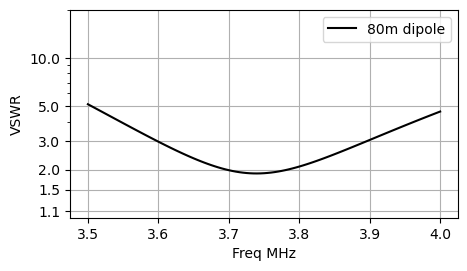

In [11]:
from necutil import nec5_sim_stdio3,plot_vswr,trim_res_freq,find_vswr_bw
import numpy as np

# Simple dipole template, height = 30 meters
AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
necstr = """CE Dipole
GW 1 10 0 0 30 0 {len} 30 0.000814
GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {fnum} 0 0 {flow} {fstep}
XQ 0
EN
"""

freq = 3.75
y_est = 142.646 / freq / 2                  # Estimated half-dipole length (m)
y = trim_res_freq(necstr, freq, y_est, tol=0.001)
print(f'Half element length (m): {y:.2f}')

res = nec5_sim_stdio3([necstr.format(len=y, fnum=101, flow=3.5, fstep=0.005)])
zs = res[0][0][0]         # freqs, zs
print(f'Impedance at midpoint: {zs[50]}')
s = necstr.format(len=y, fnum='{fnum}', flow='{flow}', fstep='{fstep}')
bw = find_vswr_bw(s, 2.0, 3.5, 4.0, fnum=11, tol=0.001)
print(f'Bandwidth for VSWR <= 2.0 (MHz): {bw:.3f}')
plot_vswr([zs], tags=['80m dipole'])





## Add Series Section Matching

Next we'll add series section matching to minimize the VSWR at the band's midpoint. This scheme is described in the Regier paper referenced below and in many other sources, e.g.:

* Regier, F., "Impedance Matching  with a Series Transmission Line Section", *Proc. IEEE*, Vol. 59, No. 7, July 1971, pp.1133-1134
* Cebik, L.B. "Series Matching: A Review" [http://www.antentop.org/w4rnl.001/ser.html](http://www.antentop.org/w4rnl.001/ser.html)
* Leeson, D.B. "Impedance Matching" [https://web.ece.ucsb.edu/~long/ece145a/zmatch.pdf](https://web.ece.ucsb.edu/~long/ece145a/zmatch.pdf)

<img src="../Cad/Series_Section_Match_2.svg" alt="Drawing" style="width: 600px;"/>

In [16]:

# The formulas for the segment lengths are implemented in ssm_thetas() -- see "040_Matching.ipynb"
# 'zs[50][1]' is the feedpoint impedance at band center calculated in the previous section
# (theta_a0, theta_b0) and (theta_a1, theta_b1) are two distinct solutions for the electrical lengths (degrees)
#   of the z0a and z0b transmission line sections
from necutil import ssm_thetas
thetas = ssm_thetas(zs[50][1], z0a=50, z0b=75)
print(thetas)           

# Convert from degrees to meters (required by NEC5 'TL' element)
lenm = 299.792458 / 3.75 * thetas / 360.0              # len(a), len(b), len(a)(second solution), len(b)(second solution)
print(lenm)

# Solutions: 
#  lengths of z0a,z0b (degrees);  (18.07,51.51) or (161.80,128.48)

[ 18.06727386  51.51656131 161.7955682  128.48343869]
[ 4.01217218 11.44020485 35.9296971  28.53212289]


First matching section solution:
Impedance at midpoint: [3.75, (49.991-0.0014028j)]
Bandwidth for VSWR <= 2.0 (MHz): 0.323


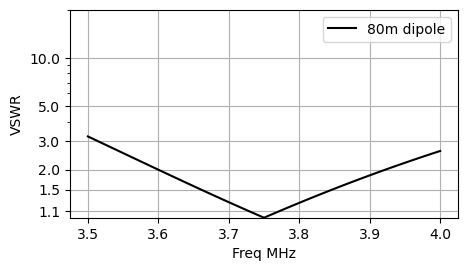

In [21]:
#
# Same antenna, but with two series transmission lines added:
#
necstr_tl = """CE Dipole
GW 1 10 0 0 30 0 {len} 30 0.000814
GW 2 1 0 0 2 0 0.001 2 0.001
GW 3 1 0 0 1 0 0.001 1 0.001
GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
TL 1 -1 2 -1 {zoa} {len_a} 0 0 0 0
TL 2 -1 3 -1 {zob} {len_b} 0 0 0 0
EX 4 3 1 1 1.0 0.0
FR 0 {fnum} 0 0 {flow} {fstep}
XQ 0
EN
"""

print('First matching section solution:')
res = nec5_sim_stdio3([necstr_tl.format(len=y, zoa=50, zob=75, len_a=lenm[0], len_b=lenm[1], fnum=101, flow=3.5, fstep=0.005)])
zs = res[0][0][0]         # freqs, zs
print(f'Impedance at midpoint: {zs[50]}')
s = necstr_tl.format(len=y, zoa=50, zob=75, len_a=lenm[0], len_b=lenm[1], fnum='{fnum}', flow='{flow}', fstep='{fstep}')
bw = find_vswr_bw(s, 2.0, 3.5, 4.0, fnum=11, tol=0.001)
print(f'Bandwidth for VSWR <= 2.0 (MHz): {bw:.3f}')
plot_vswr([zs], tags=['80m dipole'])



Second matching section solution:
Impedance at midpoint: [3.75, (50.006-0.0063626j)]
Bandwidth for VSWR <= 2.0 (MHz): 0.382


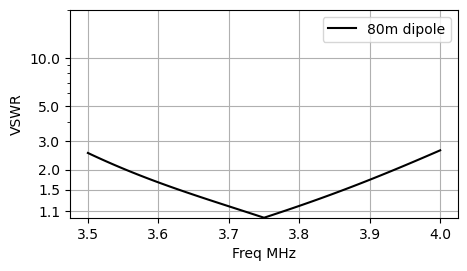

In [22]:

print('Second matching section solution:')
res = nec5_sim_stdio3([necstr_tl.format(len=y, zoa=50, zob=75, len_a=lenm[2], len_b=lenm[3], fnum=101, flow=3.5, fstep=0.005)])
zs = res[0][0][0]         # freqs, zs
print(f'Impedance at midpoint: {zs[50]}')
s = necstr_tl.format(len=y, zoa=50, zob=75, len_a=lenm[2], len_b=lenm[3], fnum='{fnum}', flow='{flow}', fstep='{fstep}')
bw = find_vswr_bw(s, 2.0, 3.5, 4.0, fnum=11, tol=0.001)
print(f'Bandwidth for VSWR <= 2.0 (MHz): {bw:.3f}')
plot_vswr([zs], tags=['80m dipole'])


First matching network solution:
    * section 'a': 50 ohms, length 4.0 meters         (lengths not corrected for velocity factor)
    * section 'b': 75 ohms, length 11.4 meters
    * bandwidth (VSWR < 2.0): 323 kHz

Second matching network solution:
    section 'a': 50 ohms, length 35.9 meters 
    section 'b': 75 ohms, length 28.5 meters
    bandwidth (VSWR < 2.0): 382 kHz



## Transmission Line Resonator Matching

Some published designs utilize the 'Transmission Line Resonator' matching arrangement with 1/4 $\lambda$ and 1 $\lambda$ sections as depicted below.

* Witt, F., "A Simple Broadband Dipole for 80 Meters", *QST*, Sep. 1993, pp.27-30,76
* Huggins, J.S. "Wideband 80m Dipole" [https://www.hamradio.me/antennas/wideband-80m-dipole-antenna.html](https://www.hamradio.me/antennas/wideband-80m-dipole-antenna.html)


<img src="../Cad/Series_Section_Match_3.svg" alt="Drawing" style="width: 600px;"/>

Bandwidth for VSWR <= 2.0 (MHz): 0.429


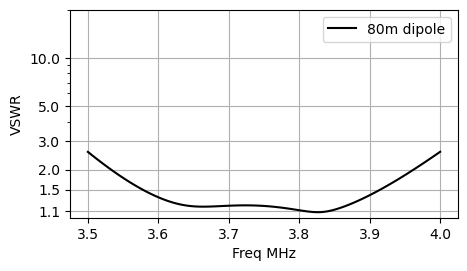

In [26]:

# Same as previous examples, with 360 and 90 degree section lengths
thetas = np.array([360, 90])
lenm = 299.792458 / 3.75 * thetas / 360.0              # Convert from degrees to meters (required by NEC5 'TL' element)

res = nec5_sim_stdio3([necstr_tl.format(len=y, zoa=50, zob=75, len_a=lenm[0], len_b=lenm[1], fnum=101, flow=3.5, fstep=0.005)])
zs = res[0][0][0]         # freqs, zs
# print(f'Impedance at midpoint: {zs[50]}')
s = necstr_tl.format(len=y, zoa=50, zob=75, len_a=lenm[0], len_b=lenm[1], fnum='{fnum}', flow='{flow}', fstep='{fstep}')
bw = find_vswr_bw(s, 2.0, 3.5, 4.0, fnum=11, tol=0.001)
print(f'Bandwidth for VSWR <= 2.0 (MHz): {bw:.3f}')
plot_vswr([zs], tags=['80m dipole'])

In [25]:
lenm

array([ 4.01217218, 11.44020485, 35.9296971 , 28.53212289])

In [14]:
thetas

array([ 18.06727386,  51.51656131, 161.7955682 , 128.48343869])